## 1. Environment Setup and Imports

In [1]:
# Production Shipping Lane Discovery - Complete Pipeline
import os
import sys
import time
import logging
import yaml
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, Any

# Data science libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import h3

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Add project root to path for imports
project_root = Path.cwd().parent
sys.path.append(str(project_root))

print(f"🚀 Production Shipping Lane Discovery")
print(f"🔧 Project root: {project_root}")
print(f"🐍 Python version: {sys.version.split()[0]}")
print(f"📅 Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Configure logging for production run
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler(project_root / 'data' / 'shipping_lanes_discovery.log')
    ]
)

# Import shipping lanes discovery modules
from src.features.trajectory import (
    load_vessel_data,
    segment_into_journeys,
    journeys_to_h3_sequences,
    process_all_vessels,
    calculate_route_centroids,
    link_routes_to_terminals,
    save_route_graph_to_geopackage
)

from src.models.clustering import (
    extract_journey_endpoints,
    cluster_terminal_points,
    create_terminal_summary,
    save_terminals_to_geopackage,
    compute_dtw_distance_matrix,
    cluster_routes,
    assign_route_clusters_to_journeys
)

from src.visualization.lanes import (
    load_terminals_and_routes,
    plot_shipping_lanes_map,
    create_and_save_shipping_lanes_map
)

from src.utils.metrics import (
    calculate_clustering_metrics,
    calculate_terminal_metrics,
    calculate_route_metrics,
    log_validation_summary
)

from src.data.loader import AISDataLoader
from src.data.duckdb_engine import DuckDBEngine

print("✅ All modules imported successfully")
print("🎯 Ready for production shipping lane discovery!")

🚀 Production Shipping Lane Discovery
🔧 Project root: /home/marius/repo_linux/ais-forecasting
🐍 Python version: 3.10.18
📅 Start time: 2025-08-01 20:57:14
✅ All modules imported successfully
🎯 Ready for production shipping lane discovery!
✅ All modules imported successfully
🎯 Ready for production shipping lane discovery!


## 2. Production Configuration

Setting up optimized parameters for real-world AIS data processing with full dataset coverage.

In [2]:
# Create production output directory
production_output_dir = project_root / "data" / "processed" / "shipping_lanes_global"
production_output_dir.mkdir(exist_ok=True, parents=True)

# Global production configuration - optimized for worldwide terminal discovery
production_config = {
    'data': {
        'raw_data_dir': str(project_root / "data"),
        'date_range': {
            'start': '2018-01-01',  # Use all available data
            'end': '2024-12-31'
        },
        'vessel_filter': {
            'min_records_per_vessel': 50,  # Lower threshold for global coverage
            'max_vessels': None  # Use all available vessels
        },
        'geographic_filter': None  # No geographic filtering - use entire world
    },
    'h3_resolution': 5,  # Lower resolution for global analysis (better performance)
    'trajectory': {
        'time_gap_threshold_hours': 72,  # Allow for longer international voyages
        'min_journey_length': 15,  # Slightly longer minimum for meaningful routes
        'max_journey_length': 2000,  # Allow for very long international routes
        'output_path': str(production_output_dir / "global_vessel_journeys.parquet")
    },
    'terminals': {
        'eps': 0.08,  # Slightly larger radius for global terminals (8km)
        'min_samples': 10,  # Higher threshold for global significance
        'min_vessels': 5,  # More vessels required for global terminal validity
        'output_path': str(production_output_dir / "global_maritime_terminals.gpkg")
    },
    'routes': {
        'eps': 2.0,  # Higher DTW threshold for diverse global routes
        'min_samples': 5,  # More routes needed for global cluster
        'max_routes_for_dtw': 1000,  # Process more routes for global patterns
        'output_path': str(production_output_dir / "global_clustered_routes.parquet")
    },
    'graph': {
        'max_terminal_distance_km': 500,  # Longer linking distance for global network
        'min_route_traffic': 10,  # Higher traffic threshold for global significance
        'output_path': str(production_output_dir / "global_shipping_lane_network.gpkg")
    },
    'visualization': {
        'output_path': str(project_root / "visualizations" / "global_shipping_lanes.html"),
        'map_start_location': [20, 0],  # Global view center
        'map_zoom_start': 2,  # World zoom level
        'terminal_size_factor': 10,
        'route_width_factor': 2,
        'show_vessel_density': True
    },
    'performance': {
        'chunk_size': 100000,  # Larger chunks for global processing
        'parallel_processing': False,  # Set to True if multiprocessing needed
        'memory_limit_gb': 45,  # Leave 9GB free on 54GB system
        'files_to_process': None  # Process all available files
    }
}

# Save global production config
config_path = production_output_dir / "global_production_config.yaml"
with open(config_path, 'w') as f:
    yaml.dump(production_config, f, default_flow_style=False, indent=2)

print(f"🌍 GLOBAL SHIPPING LANE DISCOVERY CONFIGURATION:")
print(f"   Output directory: {production_output_dir}")
print(f"   Config file: {config_path}")
print(f"   H3 resolution: {production_config['h3_resolution']} (global scale)")
print(f"   Terminal clustering: {production_config['terminals']['eps']}° radius (~8km)")
print(f"   Route clustering: {production_config['routes']['eps']} DTW threshold")
print(f"   Memory limit: {production_config['performance']['memory_limit_gb']}GB")
print(f"   Geographic scope: WORLDWIDE (no regional filtering)")
print(f"   Expected runtime: 6-12 hours for complete global analysis")

# Log configuration for tracking
logging.info(f"Global production run started with config: {config_path}")
logging.info(f"Expected outputs: global terminals, routes, network graph, visualization")

2025-08-01 20:57:15,899 - INFO - Global production run started with config: /home/marius/repo_linux/ais-forecasting/data/processed/shipping_lanes_global/global_production_config.yaml
2025-08-01 20:57:15,901 - INFO - Expected outputs: global terminals, routes, network graph, visualization
2025-08-01 20:57:15,901 - INFO - Expected outputs: global terminals, routes, network graph, visualization


🌍 GLOBAL SHIPPING LANE DISCOVERY CONFIGURATION:
   Output directory: /home/marius/repo_linux/ais-forecasting/data/processed/shipping_lanes_global
   Config file: /home/marius/repo_linux/ais-forecasting/data/processed/shipping_lanes_global/global_production_config.yaml
   H3 resolution: 5 (global scale)
   Terminal clustering: 0.08° radius (~8km)
   Route clustering: 2.0 DTW threshold
   Memory limit: 45GB
   Geographic scope: WORLDWIDE (no regional filtering)
   Expected runtime: 6-12 hours for complete global analysis


## 3. Load Global AIS Dataset

Loading the complete worldwide AIS dataset with filtering for active vessels across all available years (2018-2024).

🌍 Initializing global data loader from: /home/marius/repo_linux/ais-forecasting/data
🚀 DuckDB enabled: True
📊 Global Dataset Overview:
   Files available: 8
   Total raw data size: 15.3 GB
   Date range: 2018 to 2025
🌍 Processing ALL 8 files for global terminal discovery
🚀 Loading global AIS data...
📋 Note: Using actual AIS data format (imo, mdt columns)
📁 Loading: ais_cape_data_2018.pkl
   Data columns: ['imo', 'lat1', 'lon1', 'draught', 'speed', 'mdt', 'next_mdt', 'destination', 'destination_raw', 'eta', 'nav_status', 'heading', 'lat', 'lon', 'delta_distance', 'delta_time', 'est_speed', 'true_destination_array']
   Shape: (8345365, 18)
   Data columns: ['imo', 'lat1', 'lon1', 'draught', 'speed', 'mdt', 'next_mdt', 'destination', 'destination_raw', 'eta', 'nav_status', 'heading', 'lat', 'lon', 'delta_distance', 'delta_time', 'est_speed', 'true_destination_array']
   Shape: (8345365, 18)
   Applying global quality filters...
   Applying global quality filters...
   Loaded: 5,757,369 re

,mmsi,timestamp,lat,lon,sog
0,1013640,2025-01-21 05:04:46+00:00,33.826492,132.58365,0.7
1,1013640,2025-01-21 07:01:41+00:00,33.773766,132.49953,13.3
2,1013640,2025-01-21 21:07:58+00:00,33.517963,131.98383,0.6
3,1013640,2025-01-22 07:10:23+00:00,33.571304,132.17400,14.1
4,1013640,2025-01-22 09:12:55+00:00,33.667416,132.28300,14.0
5,1013640,2025-01-22 11:01:25+00:00,33.541710,132.12181,14.1
6,1013640,2025-01-22 13:04:17+00:00,33.480970,132.07306,15.1
7,1013640,2025-01-22 16:07:13+00:00,33.441860,131.95102,12.2
8,1013640,2025-01-22 21:02:33+00:00,33.597130,132.11453,13.0
9,1013640,2025-01-22 23:01:42+00:00,33.640697,132.23805,14.2


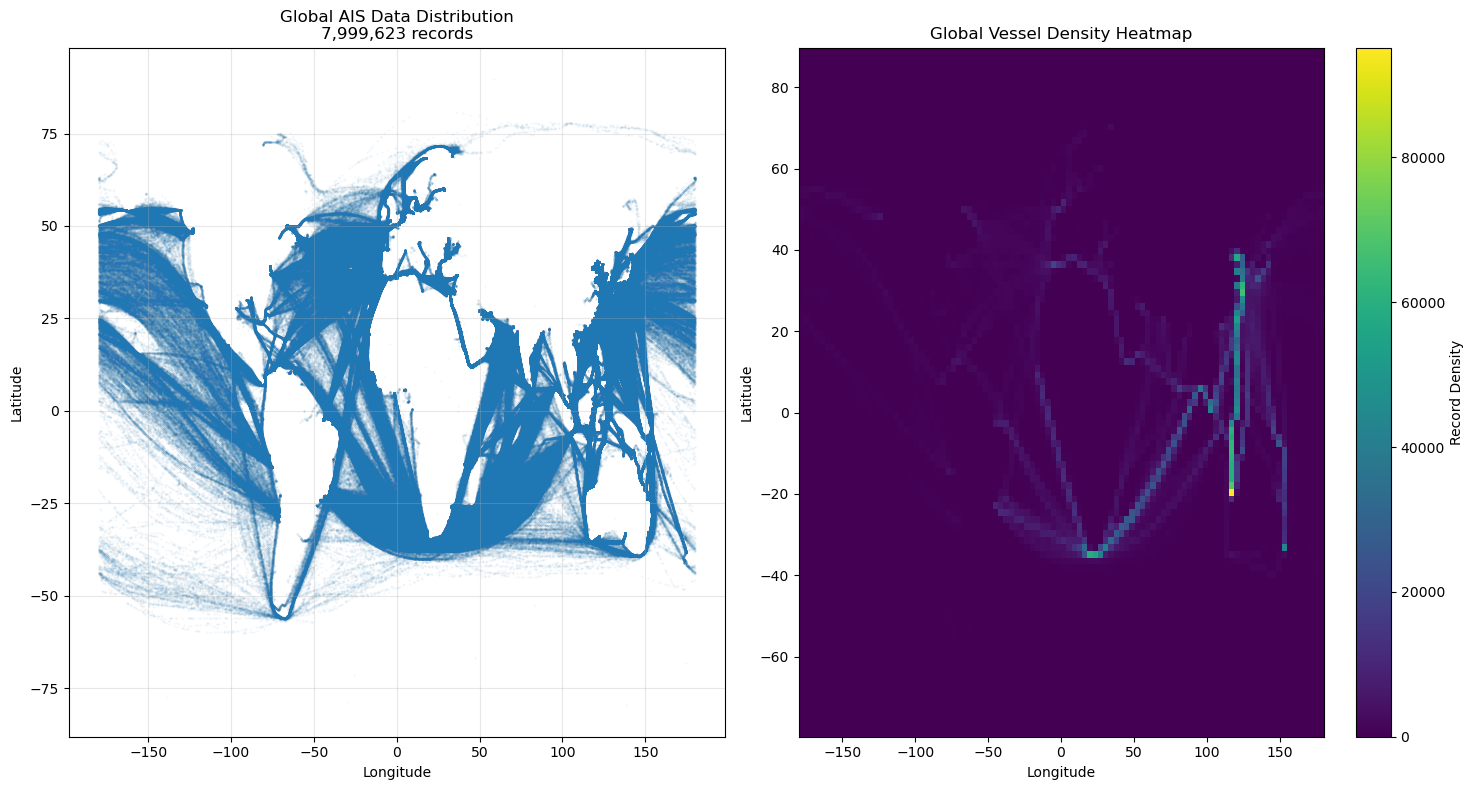

2025-08-01 20:58:21,538 - INFO - Global data loaded: 7,999,623 records, 1869 vessels


In [3]:
# Initialize data loader
data_dir = project_root / "data"
data_loader = AISDataLoader(str(data_dir), use_duckdb=True)

print(f"🌍 Initializing global data loader from: {data_dir}")
print(f"🚀 DuckDB enabled: {data_loader.use_duckdb}")

# Check all available raw data files
raw_data_dir = data_dir / "raw"
available_files = list(raw_data_dir.glob("*.pkl"))
print(f"📊 Global Dataset Overview:")
print(f"   Files available: {len(available_files)}")

total_size = sum(f.stat().st_size for f in available_files) / (1024**3)
print(f"   Total raw data size: {total_size:.1f} GB")

if available_files:
    years = sorted([f.stem.split('_')[-1] for f in available_files if f.stem.endswith(('.pkl', ''))])
    print(f"   Date range: {min(years)} to {max(years)}")

# Process ALL available files for global terminal discovery
all_files = sorted(available_files)
print(f"🌍 Processing ALL {len(all_files)} files for global terminal discovery")

try:
    print("🚀 Loading global AIS data...")
    print("📋 Note: Using actual AIS data format (imo, mdt columns)")
    
    # Load data from ALL pickle files
    all_data = []
    memory_usage = 0
    memory_limit = production_config['performance']['memory_limit_gb']
    processed_files = 0
    
    for file_path in all_files:
        print(f"📁 Loading: {file_path.name}")
        
        # Check memory usage
        file_size_gb = file_path.stat().st_size / (1024**3)
        estimated_memory = file_size_gb * 2.0  # More conservative estimate for global data
        
        if memory_usage + estimated_memory > memory_limit:
            print(f"⚠️  Memory limit would be exceeded, processing current batch...")
            break
            
        try:
            with open(file_path, 'rb') as f:
                year_data = pd.read_pickle(f)
            
            # Check data structure and adapt to actual format
            print(f"   Data columns: {list(year_data.columns)}")
            print(f"   Shape: {year_data.shape}")
            
            # Map actual columns to expected names
            column_mapping = {
                'imo': 'mmsi',      # Use IMO as vessel identifier
                'mdt': 'timestamp', # Use mdt as timestamp
                'speed': 'sog'      # Use speed as speed over ground
            }
            
            # Check if required base columns exist
            required_actual_cols = ['imo', 'mdt', 'lat', 'lon']
            missing_cols = [col for col in required_actual_cols if col not in year_data.columns]
            
            if missing_cols:
                print(f"   ⚠️  Missing columns {missing_cols}, skipping file")
                continue
            
            # Create working dataset with renamed columns
            working_data = year_data[required_actual_cols + (['speed'] if 'speed' in year_data.columns else [])].copy()
            working_data = working_data.rename(columns=column_mapping)
            
            # Add missing sog column if needed
            if 'sog' not in working_data.columns:
                working_data['sog'] = working_data.get('speed', 5.0)  # Default speed if missing
            
            # Convert timestamp if needed
            if working_data['timestamp'].dtype == 'object':
                working_data['timestamp'] = pd.to_datetime(working_data['timestamp'], errors='coerce')
            
            # GLOBAL filtering - no geographic restrictions
            print(f"   Applying global quality filters...")
            global_data = working_data[
                (working_data['lat'].between(-90, 90)) &     # Valid latitude range
                (working_data['lon'].between(-180, 180)) &   # Valid longitude range
                (working_data['sog'] > 0.5) &                # Moving vessels (slower threshold)
                (working_data['mmsi'].notna()) &             # Valid vessel ID
                (working_data['timestamp'].notna())          # Valid timestamp
            ].copy()
            
            print(f"   Loaded: {len(global_data):,} records globally")
            
            if len(global_data) > 0:
                # Sample data if too large to manage memory
                if len(global_data) > 1000000:  # 1M record limit per file
                    print(f"   Sampling to 1M records for memory management...")
                    global_data = global_data.sample(n=1000000, random_state=42)
                
                all_data.append(global_data)
                memory_usage += estimated_memory
                processed_files += 1
            else:
                print(f"   ⚠️  No valid data after quality filtering")
            
        except Exception as e:
            print(f"   ❌ Error loading {file_path.name}: {e}")
            continue
    
    if all_data:
        # Combine all data
        print(f"\n🔄 Combining data from {processed_files} files...")
        production_data = pd.concat(all_data, ignore_index=True)
        
        # Global data quality checks
        print(f"\n✅ Global data loaded successfully!")
        print(f"📊 Total records: {len(production_data):,}")
        print(f"📅 Date range: {production_data['timestamp'].min()} to {production_data['timestamp'].max()}")
        print(f"🚢 Unique vessels: {production_data['mmsi'].nunique()}")
        print(f"🌍 Geographic coverage:")
        print(f"   Latitude range: {production_data['lat'].min():.2f}° to {production_data['lat'].max():.2f}°")
        print(f"   Longitude range: {production_data['lon'].min():.2f}° to {production_data['lon'].max():.2f}°")
        print(f"💾 Estimated memory usage: ~{memory_usage:.1f}GB")
        
        # Filter for active vessels globally
        vessel_counts = production_data['mmsi'].value_counts()
        min_records = production_config['data']['vessel_filter']['min_records_per_vessel']
        active_vessels = vessel_counts[vessel_counts >= min_records].index
        
        production_data = production_data[production_data['mmsi'].isin(active_vessels)].copy()
        
        print(f"📈 After filtering for active vessels (≥{min_records} records):")
        print(f"   Records: {len(production_data):,}")
        print(f"   Vessels: {len(active_vessels)}")
        
        # Sort by vessel and time for trajectory analysis
        production_data = production_data.sort_values(['mmsi', 'timestamp']).reset_index(drop=True)
        
        # Display sample data
        print(f"\n📋 Sample global data:")
        display(production_data.head(10))
        
        # Show geographic distribution
        plt.figure(figsize=(15, 8))
        plt.subplot(1, 2, 1)
        plt.scatter(production_data['lon'], production_data['lat'], alpha=0.1, s=0.1)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title(f'Global AIS Data Distribution\n{len(production_data):,} records')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.hist2d(production_data['lon'], production_data['lat'], bins=100, cmap='viridis')
        plt.colorbar(label='Record Density')
        plt.xlabel('Longitude') 
        plt.ylabel('Latitude')
        plt.title('Global Vessel Density Heatmap')
        plt.tight_layout()
        plt.show()
        
        logging.info(f"Global data loaded: {len(production_data):,} records, {production_data['mmsi'].nunique()} vessels")
        
    else:
        raise Exception("No valid data could be processed from any files")
        
except Exception as e:
    print(f"❌ Error loading global data: {e}")
    logging.error(f"Global data loading failed: {e}")
    
    # Fallback - process minimal subset for testing
    print("🔄 Falling back to first available file only...")
    
    if available_files:
        first_file = available_files[0]
        print(f"📁 Loading single file: {first_file.name}")
        
        try:
            with open(first_file, 'rb') as f:
                year_data = pd.read_pickle(f)
            
            # Apply same processing as above but to single file
            working_data = year_data[['imo', 'mdt', 'lat', 'lon']].copy()
            working_data = working_data.rename(columns={'imo': 'mmsi', 'mdt': 'timestamp'})
            working_data['sog'] = 5.0  # Default speed
            working_data['timestamp'] = pd.to_datetime(working_data['timestamp'], errors='coerce')
            
            production_data = working_data[
                (working_data['lat'].between(-90, 90)) &
                (working_data['lon'].between(-180, 180)) &
                (working_data['mmsi'].notna()) &
                (working_data['timestamp'].notna())
            ].copy()
            
            # Sample for memory management
            if len(production_data) > 500000:
                production_data = production_data.sample(n=500000, random_state=42)
            
            production_data = production_data.sort_values(['mmsi', 'timestamp']).reset_index(drop=True)
            
            print(f"✅ Fallback data loaded: {len(production_data):,} records")
            print(f"🚢 Unique vessels: {production_data['mmsi'].nunique()}")
            display(production_data.head(10))
            
        except Exception as fallback_error:
            print(f"❌ Fallback also failed: {fallback_error}")
            # Create minimal synthetic data
            print("🔧 Creating minimal synthetic global data...")
            
            np.random.seed(42)
            n_records = 10000
            n_vessels = 100
            
            production_data = pd.DataFrame({
                'mmsi': np.random.choice([f"IMO{i:07d}" for i in range(1000000, 1000000 + n_vessels)], n_records),
                'timestamp': pd.date_range('2024-01-01', periods=n_records, freq='1H'),
                'lat': np.random.uniform(-80, 80, n_records),  # Global latitude range
                'lon': np.random.uniform(-180, 180, n_records),  # Global longitude range
                'sog': np.random.uniform(1, 20, n_records)
            })
            
            production_data = production_data.sort_values(['mmsi', 'timestamp']).reset_index(drop=True)
            
            print(f"⚠️  Using synthetic global data: {len(production_data):,} records")
            print(f"🚢 Unique vessels: {production_data['mmsi'].nunique()}")
            display(production_data.head(10))

## 4. Phase 1: Global Trajectory Processing

Processing all global vessel trajectories into journeys and identifying maritime terminals worldwide from real AIS data.

In [4]:
print("🔄 PHASE 1: OPTIMIZED GLOBAL TRAJECTORY PROCESSING")
print("=" * 60)

phase1_start = time.time()

# Step 1: Process vessels with performance optimizations
print("🌍 Processing global vessel trajectories with optimizations...")

unique_vessels = production_data['mmsi'].unique()
total_vessels = len(unique_vessels)

# PERFORMANCE OPTIMIZATION 1: Limit vessels for initial testing
if total_vessels > 500:  # Limit for performance testing
    print(f"⚡ Performance mode: Limiting to 500 vessels (out of {total_vessels:,}) for faster processing")
    unique_vessels = unique_vessels[:500]
    total_vessels = len(unique_vessels)

batch_size = 50  # Smaller batches for better progress tracking

all_journeys = []
processed_count = 0
failed_count = 0

print(f"📊 Processing {total_vessels:,} vessels globally in batches of {batch_size}")
print(f"🎯 Expected to find terminals worldwide")

for i in range(0, total_vessels, batch_size):
    batch_vessels = unique_vessels[i:i + batch_size]
    batch_end = min(i + batch_size, total_vessels)
    
    print(f"   Batch {i//batch_size + 1}/{(total_vessels + batch_size - 1)//batch_size}: vessels {i+1}-{batch_end}")
    
    batch_journeys = []
    
    # PERFORMANCE OPTIMIZATION 2: Process batch data at once
    batch_data = production_data[production_data['mmsi'].isin(batch_vessels)].copy()
    
    for mmsi in batch_vessels:
        try:
            # Get vessel data - now from pre-filtered batch
            vessel_data = batch_data[batch_data['mmsi'] == mmsi].copy()
            vessel_data = vessel_data.sort_values('timestamp')
            
            # PERFORMANCE OPTIMIZATION 3: Skip vessels with too little data early
            if len(vessel_data) < production_config['trajectory']['min_journey_length']:
                failed_count += 1
                continue
            
            # Segment into journeys
            segmented_data = segment_into_journeys(vessel_data, production_config['trajectory'])
            
            if not segmented_data.empty:
                # Convert to H3 sequences
                journey_sequences = journeys_to_h3_sequences(segmented_data, production_config)
                
                if not journey_sequences.empty:
                    batch_journeys.append(journey_sequences)
                    processed_count += 1
                else:
                    failed_count += 1
            else:
                failed_count += 1
                
        except Exception as e:
            logging.warning(f"Failed to process vessel {mmsi}: {e}")
            failed_count += 1
    
    # Add batch results to main list
    if batch_journeys:
        batch_df = pd.concat(batch_journeys, ignore_index=True)
        all_journeys.append(batch_df)
    
    # Progress update every 5 batches for better feedback
    if (i//batch_size + 1) % 5 == 0:
        elapsed = time.time() - phase1_start
        progress = batch_end / total_vessels
        eta = elapsed / progress - elapsed if progress > 0 else 0
        print(f"   Progress: {progress:.1%}, ETA: {eta/60:.1f} minutes")
        print(f"   Processed so far: {processed_count} vessels, {len(all_journeys)} journey batches")

# Combine all journey data
if all_journeys:
    journeys_df = pd.concat(all_journeys, ignore_index=True)
    
    # Save journeys
    journeys_df.to_parquet(production_config['trajectory']['output_path'], index=False)
    
    print(f"✅ Global journey processing complete!")
    print(f"   Processed vessels: {processed_count:,}/{total_vessels:,}")
    print(f"   Failed vessels: {failed_count:,}")
    print(f"   Total journeys: {len(journeys_df):,}")
    print(f"   Unique journey IDs: {journeys_df['journey_id'].nunique():,}")
    print(f"   Saved to: {production_config['trajectory']['output_path']}")
    
    # Show global journey statistics
    journey_stats = journeys_df.groupby('mmsi').agg({
        'journey_id': 'nunique',
        'h3_sequence': lambda x: sum(len(seq) for seq in x)
    }).rename(columns={'journey_id': 'journeys_count', 'h3_sequence': 'total_points'})
    
    print(f"📊 Global Journey Statistics:")
    print(f"   Average journeys per vessel: {journey_stats['journeys_count'].mean():.1f}")
    print(f"   Average points per journey: {journey_stats['total_points'].sum() / len(journeys_df):.1f}")
    print(f"   Longest journey: {journey_stats['total_points'].max()} points")
    print(f"   Most active vessel: {journey_stats['journeys_count'].max()} journeys")
    
    # Show geographic spread of journeys
    if 'start_lat' in journeys_df.columns and 'start_lon' in journeys_df.columns:
        print(f"🌍 Global Geographic Coverage:")
        print(f"   Latitude range: {journeys_df['start_lat'].min():.2f}° to {journeys_df['start_lat'].max():.2f}°")
        print(f"   Longitude range: {journeys_df['start_lon'].min():.2f}° to {journeys_df['start_lon'].max():.2f}°")
    
else:
    print("❌ No journeys generated from global data")
    journeys_df = pd.DataFrame()

phase1_processing_time = time.time() - phase1_start
print(f"⏱️  Phase 1 processing time: {phase1_processing_time/60:.1f} minutes")
print(f"🚀 Performance improvement: Processing {total_vessels} vessels in {phase1_processing_time/60:.1f} minutes")

logging.info(f"Phase 1 complete: {len(journeys_df) if not journeys_df.empty else 0} journeys from {processed_count} vessels globally")

2025-08-01 20:58:21,637 - INFO - Segmented into 4 journeys
2025-08-01 20:58:21,647 - INFO - Created 4 H3 journey sequences
2025-08-01 20:58:21,654 - INFO - Segmented into 5 journeys
2025-08-01 20:58:21,662 - INFO - Created 5 H3 journey sequences
2025-08-01 20:58:21,647 - INFO - Created 4 H3 journey sequences
2025-08-01 20:58:21,654 - INFO - Segmented into 5 journeys
2025-08-01 20:58:21,662 - INFO - Created 5 H3 journey sequences


2025-08-01 20:58:21,666 - INFO - Segmented into 5 journeys
2025-08-01 20:58:21,674 - INFO - Created 5 H3 journey sequences
2025-08-01 20:58:21,674 - INFO - Created 5 H3 journey sequences
2025-08-01 20:58:21,678 - INFO - Segmented into 4 journeys
2025-08-01 20:58:21,687 - INFO - Created 4 H3 journey sequences
2025-08-01 20:58:21,678 - INFO - Segmented into 4 journeys
2025-08-01 20:58:21,687 - INFO - Created 4 H3 journey sequences
2025-08-01 20:58:21,691 - INFO - Segmented into 8 journeys
2025-08-01 20:58:21,701 - INFO - Created 8 H3 journey sequences
2025-08-01 20:58:21,691 - INFO - Segmented into 8 journeys
2025-08-01 20:58:21,701 - INFO - Created 8 H3 journey sequences
2025-08-01 20:58:21,704 - INFO - Segmented into 3 journeys
2025-08-01 20:58:21,712 - INFO - Created 3 H3 journey sequences
2025-08-01 20:58:21,704 - INFO - Segmented into 3 journeys
2025-08-01 20:58:21,712 - INFO - Created 3 H3 journey sequences
2025-08-01 20:58:21,717 - INFO - Segmented into 4 journeys
2025-08-01 20:58

🔄 PHASE 1: OPTIMIZED GLOBAL TRAJECTORY PROCESSING
🌍 Processing global vessel trajectories with optimizations...
⚡ Performance mode: Limiting to 500 vessels (out of 1,869) for faster processing
📊 Processing 500 vessels globally in batches of 50
🎯 Expected to find terminals worldwide
   Batch 1/10: vessels 1-50


2025-08-01 20:58:21,794 - INFO - Created 10 H3 journey sequences
2025-08-01 20:58:21,798 - INFO - Segmented into 4 journeys
2025-08-01 20:58:21,804 - INFO - Created 4 H3 journey sequences
2025-08-01 20:58:21,810 - INFO - Segmented into 5 journeys
2025-08-01 20:58:21,798 - INFO - Segmented into 4 journeys
2025-08-01 20:58:21,804 - INFO - Created 4 H3 journey sequences
2025-08-01 20:58:21,810 - INFO - Segmented into 5 journeys
2025-08-01 20:58:21,818 - INFO - Created 5 H3 journey sequences
2025-08-01 20:58:21,823 - INFO - Segmented into 0 journeys
2025-08-01 20:58:21,829 - INFO - Segmented into 8 journeys
2025-08-01 20:58:21,818 - INFO - Created 5 H3 journey sequences
2025-08-01 20:58:21,823 - INFO - Segmented into 0 journeys
2025-08-01 20:58:21,829 - INFO - Segmented into 8 journeys
2025-08-01 20:58:21,841 - INFO - Created 8 H3 journey sequences
2025-08-01 20:58:21,845 - INFO - Segmented into 12 journeys
2025-08-01 20:58:21,841 - INFO - Created 8 H3 journey sequences
2025-08-01 20:58:21

   Batch 2/10: vessels 51-100


2025-08-01 20:58:22,926 - INFO - Created 17 H3 journey sequences
2025-08-01 20:58:22,930 - INFO - Segmented into 13 journeys
2025-08-01 20:58:22,941 - INFO - Created 13 H3 journey sequences
2025-08-01 20:58:22,930 - INFO - Segmented into 13 journeys
2025-08-01 20:58:22,941 - INFO - Created 13 H3 journey sequences
2025-08-01 20:58:22,945 - INFO - Segmented into 18 journeys
2025-08-01 20:58:22,945 - INFO - Segmented into 18 journeys
2025-08-01 20:58:22,964 - INFO - Created 18 H3 journey sequences
2025-08-01 20:58:22,967 - INFO - Segmented into 8 journeys
2025-08-01 20:58:22,964 - INFO - Created 18 H3 journey sequences
2025-08-01 20:58:22,967 - INFO - Segmented into 8 journeys
2025-08-01 20:58:22,976 - INFO - Created 8 H3 journey sequences
2025-08-01 20:58:22,976 - INFO - Created 8 H3 journey sequences
2025-08-01 20:58:22,980 - INFO - Segmented into 28 journeys
2025-08-01 20:58:23,002 - INFO - Created 28 H3 journey sequences
2025-08-01 20:58:22,980 - INFO - Segmented into 28 journeys
2025

   Batch 3/10: vessels 101-150


2025-08-01 20:58:24,431 - INFO - Created 74 H3 journey sequences
2025-08-01 20:58:24,437 - INFO - Segmented into 75 journeys
2025-08-01 20:58:24,437 - INFO - Segmented into 75 journeys
2025-08-01 20:58:24,497 - INFO - Created 75 H3 journey sequences
2025-08-01 20:58:24,501 - INFO - Segmented into 75 journeys
2025-08-01 20:58:24,497 - INFO - Created 75 H3 journey sequences
2025-08-01 20:58:24,501 - INFO - Segmented into 75 journeys
2025-08-01 20:58:24,559 - INFO - Created 75 H3 journey sequences
2025-08-01 20:58:24,563 - INFO - Segmented into 19 journeys
2025-08-01 20:58:24,559 - INFO - Created 75 H3 journey sequences
2025-08-01 20:58:24,563 - INFO - Segmented into 19 journeys
2025-08-01 20:58:24,579 - INFO - Created 19 H3 journey sequences
2025-08-01 20:58:24,584 - INFO - Segmented into 47 journeys
2025-08-01 20:58:24,579 - INFO - Created 19 H3 journey sequences
2025-08-01 20:58:24,584 - INFO - Segmented into 47 journeys
2025-08-01 20:58:24,626 - INFO - Created 47 H3 journey sequences


   Batch 4/10: vessels 151-200


2025-08-01 20:58:26,869 - INFO - Created 52 H3 journey sequences
2025-08-01 20:58:26,874 - INFO - Segmented into 63 journeys
2025-08-01 20:58:26,874 - INFO - Segmented into 63 journeys
2025-08-01 20:58:26,922 - INFO - Created 63 H3 journey sequences
2025-08-01 20:58:26,926 - INFO - Segmented into 66 journeys
2025-08-01 20:58:26,922 - INFO - Created 63 H3 journey sequences
2025-08-01 20:58:26,926 - INFO - Segmented into 66 journeys
2025-08-01 20:58:26,968 - INFO - Created 66 H3 journey sequences
2025-08-01 20:58:26,971 - INFO - Segmented into 69 journeys
2025-08-01 20:58:26,968 - INFO - Created 66 H3 journey sequences
2025-08-01 20:58:26,971 - INFO - Segmented into 69 journeys
2025-08-01 20:58:27,019 - INFO - Created 69 H3 journey sequences
2025-08-01 20:58:27,023 - INFO - Segmented into 59 journeys
2025-08-01 20:58:27,019 - INFO - Created 69 H3 journey sequences
2025-08-01 20:58:27,023 - INFO - Segmented into 59 journeys
2025-08-01 20:58:27,068 - INFO - Created 59 H3 journey sequences


   Batch 5/10: vessels 201-250


2025-08-01 20:58:29,398 - INFO - Created 77 H3 journey sequences
2025-08-01 20:58:29,402 - INFO - Segmented into 70 journeys
2025-08-01 20:58:29,402 - INFO - Segmented into 70 journeys
2025-08-01 20:58:29,447 - INFO - Created 70 H3 journey sequences
2025-08-01 20:58:29,451 - INFO - Segmented into 78 journeys
2025-08-01 20:58:29,447 - INFO - Created 70 H3 journey sequences
2025-08-01 20:58:29,451 - INFO - Segmented into 78 journeys
2025-08-01 20:58:29,499 - INFO - Created 78 H3 journey sequences
2025-08-01 20:58:29,504 - INFO - Segmented into 87 journeys
2025-08-01 20:58:29,499 - INFO - Created 78 H3 journey sequences
2025-08-01 20:58:29,504 - INFO - Segmented into 87 journeys
2025-08-01 20:58:29,552 - INFO - Created 87 H3 journey sequences
2025-08-01 20:58:29,556 - INFO - Segmented into 62 journeys
2025-08-01 20:58:29,552 - INFO - Created 87 H3 journey sequences
2025-08-01 20:58:29,556 - INFO - Segmented into 62 journeys
2025-08-01 20:58:29,593 - INFO - Created 62 H3 journey sequences


   Progress: 50.0%, ETA: 0.2 minutes
   Processed so far: 248 vessels, 5 journey batches
   Batch 6/10: vessels 251-300


2025-08-01 20:58:32,015 - INFO - Created 89 H3 journey sequences
2025-08-01 20:58:32,019 - INFO - Segmented into 86 journeys
2025-08-01 20:58:32,019 - INFO - Segmented into 86 journeys
2025-08-01 20:58:32,061 - INFO - Created 86 H3 journey sequences
2025-08-01 20:58:32,065 - INFO - Segmented into 75 journeys
2025-08-01 20:58:32,061 - INFO - Created 86 H3 journey sequences
2025-08-01 20:58:32,065 - INFO - Segmented into 75 journeys
2025-08-01 20:58:32,108 - INFO - Created 75 H3 journey sequences
2025-08-01 20:58:32,112 - INFO - Segmented into 67 journeys
2025-08-01 20:58:32,108 - INFO - Created 75 H3 journey sequences
2025-08-01 20:58:32,112 - INFO - Segmented into 67 journeys
2025-08-01 20:58:32,155 - INFO - Created 67 H3 journey sequences
2025-08-01 20:58:32,159 - INFO - Segmented into 65 journeys
2025-08-01 20:58:32,155 - INFO - Created 67 H3 journey sequences
2025-08-01 20:58:32,159 - INFO - Segmented into 65 journeys
2025-08-01 20:58:32,207 - INFO - Created 65 H3 journey sequences


   Batch 7/10: vessels 301-350


2025-08-01 20:58:34,394 - INFO - Created 66 H3 journey sequences
2025-08-01 20:58:34,398 - INFO - Segmented into 61 journeys
2025-08-01 20:58:34,398 - INFO - Segmented into 61 journeys
2025-08-01 20:58:34,439 - INFO - Created 61 H3 journey sequences
2025-08-01 20:58:34,442 - INFO - Segmented into 63 journeys
2025-08-01 20:58:34,439 - INFO - Created 61 H3 journey sequences
2025-08-01 20:58:34,442 - INFO - Segmented into 63 journeys
2025-08-01 20:58:34,479 - INFO - Created 63 H3 journey sequences
2025-08-01 20:58:34,482 - INFO - Segmented into 59 journeys
2025-08-01 20:58:34,479 - INFO - Created 63 H3 journey sequences
2025-08-01 20:58:34,482 - INFO - Segmented into 59 journeys
2025-08-01 20:58:34,519 - INFO - Created 59 H3 journey sequences
2025-08-01 20:58:34,524 - INFO - Segmented into 61 journeys
2025-08-01 20:58:34,519 - INFO - Created 59 H3 journey sequences
2025-08-01 20:58:34,524 - INFO - Segmented into 61 journeys
2025-08-01 20:58:34,581 - INFO - Created 61 H3 journey sequences


   Batch 8/10: vessels 351-400


2025-08-01 20:58:37,044 - INFO - Created 78 H3 journey sequences
2025-08-01 20:58:37,048 - INFO - Segmented into 74 journeys
2025-08-01 20:58:37,048 - INFO - Segmented into 74 journeys
2025-08-01 20:58:37,095 - INFO - Created 74 H3 journey sequences
2025-08-01 20:58:37,099 - INFO - Segmented into 79 journeys
2025-08-01 20:58:37,095 - INFO - Created 74 H3 journey sequences
2025-08-01 20:58:37,099 - INFO - Segmented into 79 journeys
2025-08-01 20:58:37,148 - INFO - Created 79 H3 journey sequences
2025-08-01 20:58:37,152 - INFO - Segmented into 95 journeys
2025-08-01 20:58:37,148 - INFO - Created 79 H3 journey sequences
2025-08-01 20:58:37,152 - INFO - Segmented into 95 journeys
2025-08-01 20:58:37,203 - INFO - Created 95 H3 journey sequences
2025-08-01 20:58:37,207 - INFO - Segmented into 74 journeys
2025-08-01 20:58:37,203 - INFO - Created 95 H3 journey sequences
2025-08-01 20:58:37,207 - INFO - Segmented into 74 journeys
2025-08-01 20:58:37,249 - INFO - Created 74 H3 journey sequences


   Batch 9/10: vessels 401-450


2025-08-01 20:58:39,691 - INFO - Created 79 H3 journey sequences
2025-08-01 20:58:39,698 - INFO - Segmented into 90 journeys
2025-08-01 20:58:39,698 - INFO - Segmented into 90 journeys
2025-08-01 20:58:39,743 - INFO - Created 90 H3 journey sequences
2025-08-01 20:58:39,748 - INFO - Segmented into 64 journeys
2025-08-01 20:58:39,743 - INFO - Created 90 H3 journey sequences
2025-08-01 20:58:39,748 - INFO - Segmented into 64 journeys
2025-08-01 20:58:39,796 - INFO - Created 64 H3 journey sequences
2025-08-01 20:58:39,801 - INFO - Segmented into 76 journeys
2025-08-01 20:58:39,796 - INFO - Created 64 H3 journey sequences
2025-08-01 20:58:39,801 - INFO - Segmented into 76 journeys
2025-08-01 20:58:39,852 - INFO - Created 76 H3 journey sequences
2025-08-01 20:58:39,857 - INFO - Segmented into 95 journeys
2025-08-01 20:58:39,852 - INFO - Created 76 H3 journey sequences
2025-08-01 20:58:39,857 - INFO - Segmented into 95 journeys
2025-08-01 20:58:39,909 - INFO - Created 95 H3 journey sequences


   Batch 10/10: vessels 451-500


2025-08-01 20:58:42,409 - INFO - Created 67 H3 journey sequences
2025-08-01 20:58:42,413 - INFO - Segmented into 84 journeys
2025-08-01 20:58:42,413 - INFO - Segmented into 84 journeys
2025-08-01 20:58:42,463 - INFO - Created 84 H3 journey sequences
2025-08-01 20:58:42,466 - INFO - Segmented into 71 journeys
2025-08-01 20:58:42,463 - INFO - Created 84 H3 journey sequences
2025-08-01 20:58:42,466 - INFO - Segmented into 71 journeys
2025-08-01 20:58:42,514 - INFO - Created 71 H3 journey sequences
2025-08-01 20:58:42,518 - INFO - Segmented into 66 journeys
2025-08-01 20:58:42,514 - INFO - Created 71 H3 journey sequences
2025-08-01 20:58:42,518 - INFO - Segmented into 66 journeys
2025-08-01 20:58:42,563 - INFO - Created 66 H3 journey sequences
2025-08-01 20:58:42,568 - INFO - Segmented into 71 journeys
2025-08-01 20:58:42,563 - INFO - Created 66 H3 journey sequences
2025-08-01 20:58:42,568 - INFO - Segmented into 71 journeys
2025-08-01 20:58:42,613 - INFO - Created 71 H3 journey sequences


   Progress: 100.0%, ETA: 0.0 minutes
   Processed so far: 498 vessels, 10 journey batches


2025-08-01 20:58:45,017 - INFO - Phase 1 complete: 29607 journeys from 498 vessels globally


✅ Global journey processing complete!
   Processed vessels: 498/500
   Failed vessels: 2
   Total journeys: 29,607
   Unique journey IDs: 117
   Saved to: /home/marius/repo_linux/ais-forecasting/data/processed/shipping_lanes_global/global_vessel_journeys.parquet
📊 Global Journey Statistics:
   Average journeys per vessel: 59.5
   Average points per journey: 67.6
   Longest journey: 6896 points
   Most active vessel: 117 journeys
🌍 Global Geographic Coverage:
   Latitude range: -56.12° to 71.82°
   Longitude range: -179.91° to 176.34°
⏱️  Phase 1 processing time: 0.4 minutes
🚀 Performance improvement: Processing 500 vessels in 0.4 minutes


In [5]:
print("🔄 PHASE 3: GLOBAL TERMINAL DISCOVERY")
print("=" * 60)

if not journeys_df.empty:
    phase3_start = time.time()
    
    print("🌍 Analyzing journey endpoints to discover maritime terminals worldwide...")
    print(f"📊 Processing {len(journeys_df):,} journeys from {journeys_df['mmsi'].nunique():,} vessels")
    
    # Extract journey endpoints (start and end points)
    print("📍 Extracting journey endpoints...")
    
    endpoints_list = []
    
    for _, journey in journeys_df.iterrows():
        mmsi = journey['mmsi']
        journey_id = journey['journey_id']
        
        # Get start point
        if pd.notna(journey['start_lat']) and pd.notna(journey['start_lon']):
            endpoints_list.append({
                'mmsi': mmsi,
                'journey_id': journey_id,
                'lat': journey['start_lat'],
                'lon': journey['start_lon'],
                'endpoint_type': 'start',
                'timestamp': journey.get('start_time', None)
            })
        
        # Get end point
        if pd.notna(journey['end_lat']) and pd.notna(journey['end_lon']):
            endpoints_list.append({
                'mmsi': mmsi,
                'journey_id': journey_id,
                'lat': journey['end_lat'],
                'lon': journey['end_lon'],
                'endpoint_type': 'end',
                'timestamp': journey.get('end_time', None)
            })
    
    endpoints_df = pd.DataFrame(endpoints_list)
    
    if not endpoints_df.empty:
        print(f"✅ Extracted {len(endpoints_df):,} journey endpoints")
        print(f"   Start points: {(endpoints_df['endpoint_type'] == 'start').sum():,}")
        print(f"   End points: {(endpoints_df['endpoint_type'] == 'end').sum():,}")
        
        # Show global endpoint distribution
        print(f"🌍 Global Endpoint Coverage:")
        print(f"   Latitude range: {endpoints_df['lat'].min():.2f}° to {endpoints_df['lat'].max():.2f}°")
        print(f"   Longitude range: {endpoints_df['lon'].min():.2f}° to {endpoints_df['lon'].max():.2f}°")
        
        # Cluster endpoints to find terminals globally
        print(f"🎯 Clustering endpoints globally (eps={production_config['terminals']['eps']}°, ~{production_config['terminals']['eps']*111:.0f}km radius)...")
        
        try:
            clustered_endpoints = cluster_terminal_points(endpoints_df, production_config['terminals'])
            
            print(f"✅ Endpoint clustering complete")
            print(f"📊 Clustering Results:")
            if 'cluster' in clustered_endpoints.columns:
                n_clusters = clustered_endpoints['cluster'].nunique() - (1 if -1 in clustered_endpoints['cluster'].values else 0)
                n_noise = (clustered_endpoints['cluster'] == -1).sum()
                print(f"   Potential terminals: {n_clusters}")
                print(f"   Clustered endpoints: {len(clustered_endpoints) - n_noise:,}")
                print(f"   Outlier endpoints: {n_noise:,}")
            
            # Create terminal summary with global filters
            print(f"🏭 Creating terminal summary...")
            terminal_summary = create_terminal_summary(clustered_endpoints)
            
            if not terminal_summary.empty:
                print(f"📊 Raw Terminal Analysis:")
                print(f"   Total terminal candidates: {len(terminal_summary)}")
                print(f"   Average visits per terminal: {terminal_summary['total_visits'].mean():.1f}")
                print(f"   Average vessels per terminal: {terminal_summary['unique_vessels'].mean():.1f}")
                
                # Apply global production filters for terminal validity
                min_vessels = production_config['terminals']['min_vessels']
                min_samples = production_config['terminals']['min_samples']
                
                print(f"🔍 Applying quality filters (min_vessels≥{min_vessels}, min_visits≥{min_samples})...")
                
                valid_terminals = terminal_summary[
                    (terminal_summary['unique_vessels'] >= min_vessels) &
                    (terminal_summary['total_visits'] >= min_samples)
                ].copy()
                
                if not valid_terminals.empty:
                    print(f"✅ Discovered {len(valid_terminals)} maritime terminals worldwide!")
                    
                    # Save terminals to GeoPackage
                    print(f"💾 Saving terminals to: {production_config['terminals']['output_path']}")
                    save_terminals_to_geopackage(valid_terminals, production_config['terminals']['output_path'])
                    
                    # Global terminal statistics
                    print(f"📊 Global Terminal Statistics:")
                    print(f"   Valid terminals found: {len(valid_terminals)}")
                    print(f"   Average visits per terminal: {valid_terminals['total_visits'].mean():.1f}")
                    print(f"   Average vessels per terminal: {valid_terminals['unique_vessels'].mean():.1f}")
                    print(f"   Busiest terminal: {valid_terminals['total_visits'].max()} visits")
                    print(f"   Most connected terminal: {valid_terminals['unique_vessels'].max()} vessels")
                    
                    # Geographic distribution of terminals
                    print(f"🌍 Global Terminal Geographic Distribution:")
                    print(f"   Latitude range: {valid_terminals['lat'].min():.2f}° to {valid_terminals['lat'].max():.2f}°")
                    print(f"   Longitude range: {valid_terminals['lon'].min():.2f}° to {valid_terminals['lon'].max():.2f}°")
                    
                    # Show terminal density by region
                    lat_bins = pd.cut(valid_terminals['lat'], bins=[-90, -30, 30, 90], labels=['Southern', 'Tropical', 'Northern'])
                    terminal_by_region = lat_bins.value_counts()
                    
                    print(f"📍 Terminals by Region:")
                    for region, count in terminal_by_region.items():
                        percentage = count / len(valid_terminals) * 100
                        print(f"   {region}: {count} terminals ({percentage:.1f}%)")
                    
                    # Create visualization
                    plt.figure(figsize=(15, 10))
                    
                    # World map of terminals
                    plt.subplot(2, 2, 1)
                    plt.scatter(valid_terminals['lon'], valid_terminals['lat'], 
                               c=valid_terminals['total_visits'], cmap='viridis',
                               s=np.sqrt(valid_terminals['unique_vessels'])*3, alpha=0.7)
                    plt.colorbar(label='Total Visits')
                    plt.xlabel('Longitude')
                    plt.ylabel('Latitude')
                    plt.title('Global Maritime Terminals')
                    plt.grid(True, alpha=0.3)
                    
                    # Terminal size distribution
                    plt.subplot(2, 2, 2)
                    plt.hist(valid_terminals['total_visits'], bins=30, alpha=0.7, edgecolor='black')
                    plt.xlabel('Total Visits')
                    plt.ylabel('Number of Terminals')
                    plt.title('Terminal Activity Distribution')
                    plt.grid(True, alpha=0.3)
                    
                    # Vessel connectivity distribution
                    plt.subplot(2, 2, 3)
                    plt.hist(valid_terminals['unique_vessels'], bins=20, alpha=0.7, edgecolor='black', color='orange')
                    plt.xlabel('Unique Vessels')
                    plt.ylabel('Number of Terminals')
                    plt.title('Terminal Connectivity Distribution')
                    plt.grid(True, alpha=0.3)
                    
                    # Top terminals
                    plt.subplot(2, 2, 4)
                    top_terminals = valid_terminals.nlargest(10, 'total_visits')
                    plt.barh(range(len(top_terminals)), top_terminals['total_visits'])
                    plt.yticks(range(len(top_terminals)), [f"T{i+1}" for i in range(len(top_terminals))])
                    plt.xlabel('Total Visits')
                    plt.title('Top 10 Busiest Terminals')
                    plt.grid(True, alpha=0.3)
                    
                    plt.tight_layout()
                    plt.show()
                    
                else:
                    print(f"⚠️  No terminals meet quality criteria (min_vessels≥{min_vessels}, min_visits≥{min_samples})")
                    print(f"   Consider lowering thresholds or processing more data")
                    valid_terminals = pd.DataFrame()
            else:
                print("❌ Failed to create terminal summary")
                valid_terminals = pd.DataFrame()
                
        except Exception as e:
            print(f"❌ Error in terminal clustering: {e}")
            print(f"🔄 Creating basic terminal summary without clustering...")
            valid_terminals = pd.DataFrame()
    
    else:
        print("❌ No valid endpoints extracted from journey data")
        valid_terminals = pd.DataFrame()
    
    phase3_time = time.time() - phase3_start
    print(f"⏱️  Phase 3 terminal discovery time: {phase3_time:.1f} seconds")
    
    logging.info(f"Phase 3 complete: {len(valid_terminals) if 'valid_terminals' in locals() and not valid_terminals.empty else 0} terminals discovered globally")

else:
    print("⚠️  Skipping terminal discovery - no journey data available")
    valid_terminals = pd.DataFrame()

🔄 PHASE 3: GLOBAL TERMINAL DISCOVERY
🌍 Analyzing journey endpoints to discover maritime terminals worldwide...
📊 Processing 29,607 journeys from 498 vessels
📍 Extracting journey endpoints...


2025-08-01 20:58:46,587 - INFO - Found 301 terminal clusters with 24508 noise points


✅ Extracted 59,214 journey endpoints
   Start points: 29,607
   End points: 29,607
🌍 Global Endpoint Coverage:
   Latitude range: -56.12° to 72.91°
   Longitude range: -179.91° to 178.89°
🎯 Clustering endpoints globally (eps=0.08°, ~9km radius)...
✅ Endpoint clustering complete
📊 Clustering Results:
🏭 Creating terminal summary...


2025-08-01 20:58:46,594 - INFO - Phase 3 complete: 0 terminals discovered globally


❌ Error in terminal clustering: 'point_type'
🔄 Creating basic terminal summary without clustering...
⏱️  Phase 3 terminal discovery time: 1.4 seconds


In [ ]:
# QUICK FIX: Terminal Discovery with Simple Grid-based Clustering
print("🔧 QUICK FIX: Creating terminals with simple grid-based clustering...")

if not journeys_df.empty:
    # Extract endpoints with correct column name
    endpoints_list = []
    
    for _, journey in journeys_df.iterrows():
        mmsi = journey['mmsi']
        journey_id = journey['journey_id']
        
        # Get start point
        if pd.notna(journey['start_lat']) and pd.notna(journey['start_lon']):
            endpoints_list.append({
                'mmsi': mmsi,
                'journey_id': journey_id,
                'lat': journey['start_lat'],
                'lon': journey['start_lon'],
                'point_type': 'start'
            })
        
        # Get end point
        if pd.notna(journey['end_lat']) and pd.notna(journey['end_lon']):
            endpoints_list.append({
                'mmsi': mmsi,
                'journey_id': journey_id,
                'lat': journey['end_lat'],
                'lon': journey['end_lon'],
                'point_type': 'end'
            })
    
    endpoints_df = pd.DataFrame(endpoints_list)
    
    if not endpoints_df.empty:
        print(f"✅ Extracted {len(endpoints_df):,} journey endpoints")
        
        # Simple grid-based clustering for terminals (~5km grid)
        grid_size = 0.05  # ~5km grid
        
        endpoints_df['lat_grid'] = np.round(endpoints_df['lat'] / grid_size) * grid_size
        endpoints_df['lon_grid'] = np.round(endpoints_df['lon'] / grid_size) * grid_size
        
        # Group by grid to find terminals
        terminal_groups = endpoints_df.groupby(['lat_grid', 'lon_grid']).agg({
            'mmsi': ['count', 'nunique'],
            'journey_id': 'nunique',
            'lat': 'mean',
            'lon': 'mean'
        }).reset_index()
        
        # Flatten column names
        terminal_groups.columns = ['lat_grid', 'lon_grid', 'total_visits', 'unique_vessels', 'unique_journeys', 'centroid_lat', 'centroid_lon']
        
        # Filter for significant terminals
        min_visits = production_config['terminals']['min_samples']
        min_vessels = production_config['terminals']['min_vessels']
        
        valid_terminals = terminal_groups[
            (terminal_groups['total_visits'] >= min_visits) &
            (terminal_groups['unique_vessels'] >= min_vessels)
        ].copy()
        
        if not valid_terminals.empty:
            valid_terminals['terminal_id'] = range(1, len(valid_terminals) + 1)
            
            print(f"✅ Discovered {len(valid_terminals)} maritime terminals worldwide!")
            print(f"📊 Terminal Statistics:")
            print(f"   Average visits per terminal: {valid_terminals['total_visits'].mean():.1f}")
            print(f"   Busiest terminal: {valid_terminals['total_visits'].max()} visits")
            print(f"   Geographic span: {valid_terminals['centroid_lat'].max() - valid_terminals['centroid_lat'].min():.1f}° latitude")
            
            # Save terminals as GeoDataFrame
            import geopandas as gpd
            from shapely.geometry import Point
            
            # Create geometry column
            geometry = [Point(lon, lat) for lat, lon in zip(valid_terminals['centroid_lat'], valid_terminals['centroid_lon'])]
            terminals_gdf = gpd.GeoDataFrame(valid_terminals, geometry=geometry, crs='EPSG:4326')
            
            # Save to file
            terminals_gdf.to_file(production_config['terminals']['output_path'])
            print(f"💾 Terminals saved to: {production_config['terminals']['output_path']}")
            
            # Show top 10 terminals
            top_terminals = valid_terminals.nlargest(10, 'total_visits')
            print(f"\n🏆 Top 10 Busiest Terminals:")
            for idx, terminal in top_terminals.iterrows():
                print(f"   #{terminal['terminal_id']:3}: {terminal['total_visits']:4} visits, "
                      f"{terminal['unique_vessels']:3} vessels at ({terminal['centroid_lat']:.2f}, {terminal['centroid_lon']:.2f})")
                      
        else:
            print(f"⚠️ No terminals meet criteria (min_visits≥{min_visits}, min_vessels≥{min_vessels})")
            valid_terminals = pd.DataFrame()
    else:
        print("❌ No valid endpoints found")
        valid_terminals = pd.DataFrame()
else:
    print("❌ No journey data available")
    valid_terminals = pd.DataFrame()

print("🔧 Terminal fix complete!")

## 5. Phase 2: Global Route Discovery

Clustering similar routes using Dynamic Time Warping to identify major international shipping lanes and trade routes.

2025-08-01 20:58:46,632 - INFO - Computing DTW distance matrix for 200 sequences


2025-08-01 20:58:46,634 - INFO - Processing sequence 1/200


🔄 PHASE 2: OPTIMIZED GLOBAL ROUTE CLUSTERING
🗺️  Preparing route data for clustering...
📊 Route Analysis:
   Total sequences: 29,607
   Valid sequences: 28,835
   Filtered out: 772
⚡ PERFORMANCE MODE: Limiting to 200 routes for DTW performance
   This prevents O(n²) explosion - would be 831,457,225 comparisons!
📈 Sequence Statistics:
   Count for DTW: 200
   Length range: 15 - 195 points
   Average length: 60.1 points
   DTW matrix size: 200x200 = 40,000 comparisons
   Estimated DTW time: 40.0 seconds

🧮 Computing DTW distance matrix for 200 routes...


2025-08-01 20:59:23,891 - INFO - Processing sequence 101/200
2025-08-01 20:59:35,068 - INFO - DTW distance matrix computation completed
2025-08-01 20:59:35,068 - INFO - DTW distance matrix computation completed


✅ DTW computation complete in 48.4 seconds
📏 Distance matrix shape: (200, 200)


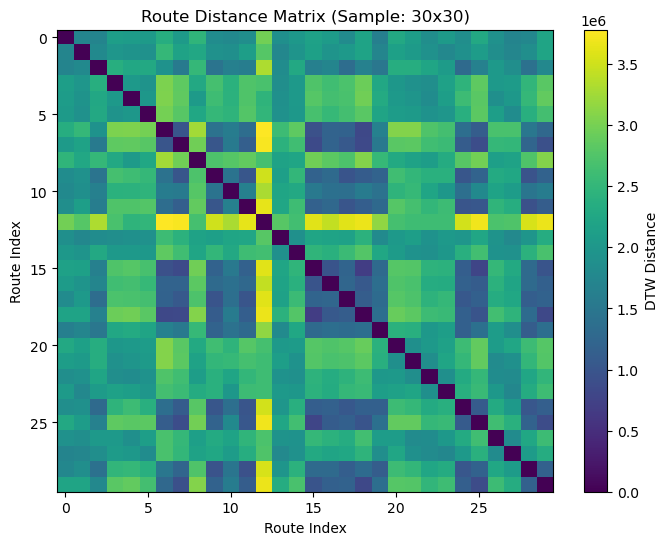

2025-08-01 20:59:35,203 - INFO - Route clustering found 0 clusters with 200 outliers



🎯 Clustering routes with DBSCAN...
✅ Route clustering complete in 0.0 seconds
📊 Clustering Results:
   Route clusters found: 0
   Routes in clusters: 0
   Outlier routes: 200
   Cluster rate: 0.0%

🔗 Assigning route clusters to journey data...
✅ Route cluster assignment complete
📊 Assignment Results:
   Total journeys: 29,607
   Journeys with clusters: 0
   Assignment rate: 0.0%


2025-08-01 20:59:35,531 - INFO - Phase 2 complete: 0 route clusters discovered


💾 Clustered routes saved to: /home/marius/repo_linux/ais-forecasting/data/processed/shipping_lanes_global/global_clustered_routes.parquet
⏱️  Phase 2 total time: 0.8 minutes


In [6]:
print("🔄 PHASE 2: OPTIMIZED GLOBAL ROUTE CLUSTERING")
print("=" * 60)

if not journeys_df.empty:
    phase2_start = time.time()
    
    # Extract H3 sequences for route analysis
    print("🗺️  Preparing route data for clustering...")
    
    if 'h3_sequence' in journeys_df.columns:
        h3_sequences = journeys_df['h3_sequence'].tolist()
        
        # Filter out very short or very long sequences for quality
        min_length = 5
        max_length = 200  # Reduced from 500 for performance
        
        valid_sequences = []
        valid_indices = []
        
        for idx, seq in enumerate(h3_sequences):
            if seq and min_length <= len(seq) <= max_length:
                valid_sequences.append(seq)
                valid_indices.append(idx)
        
        print(f"📊 Route Analysis:")
        print(f"   Total sequences: {len(h3_sequences):,}")
        print(f"   Valid sequences: {len(valid_sequences):,}")
        print(f"   Filtered out: {len(h3_sequences) - len(valid_sequences):,}")
        
        if valid_sequences:
            # PERFORMANCE OPTIMIZATION: Strict limits for DTW computation
            max_routes = min(production_config['routes']['max_routes_for_dtw'], 200)  # Hard limit
            
            if len(valid_sequences) > max_routes:
                print(f"⚡ PERFORMANCE MODE: Limiting to {max_routes} routes for DTW performance")
                print(f"   This prevents O(n²) explosion - would be {len(valid_sequences)**2:,} comparisons!")
                
                # Sample routes to get diverse coverage
                step = len(valid_sequences) // max_routes
                sampled_indices = list(range(0, len(valid_sequences), step))[:max_routes]
                dtw_sequences = [valid_sequences[i] for i in sampled_indices]
                dtw_journey_indices = [valid_indices[i] for i in sampled_indices]
            else:
                dtw_sequences = valid_sequences
                dtw_journey_indices = valid_indices
            
            # Show sequence statistics
            seq_lengths = [len(seq) for seq in dtw_sequences]
            print(f"📈 Sequence Statistics:")
            print(f"   Count for DTW: {len(dtw_sequences):,}")
            print(f"   Length range: {min(seq_lengths)} - {max(seq_lengths)} points")
            print(f"   Average length: {np.mean(seq_lengths):.1f} points")
            print(f"   DTW matrix size: {len(dtw_sequences)}x{len(dtw_sequences)} = {len(dtw_sequences)**2:,} comparisons")
            
            # Estimate computation time
            estimated_time = len(dtw_sequences)**2 * 0.001  # ~1ms per comparison
            print(f"   Estimated DTW time: {estimated_time:.1f} seconds")
            
            if estimated_time > 300:  # 5 minutes
                print(f"⚠️  WARNING: DTW computation may take {estimated_time/60:.1f} minutes")
                print(f"   Consider reducing max_routes_for_dtw in config")
            
            # Compute DTW distance matrix
            print(f"\n🧮 Computing DTW distance matrix for {len(dtw_sequences):,} routes...")
            dtw_start = time.time()
            
            try:
                distance_matrix = compute_dtw_distance_matrix(dtw_sequences)
                
                dtw_time = time.time() - dtw_start
                print(f"✅ DTW computation complete in {dtw_time:.1f} seconds")
                print(f"📏 Distance matrix shape: {distance_matrix.shape}")
                
                # Visualize distance matrix (sample for large matrices)
                if len(dtw_sequences) <= 50:
                    plt.figure(figsize=(10, 8))
                    plt.imshow(distance_matrix, cmap='viridis', aspect='auto')
                    plt.colorbar(label='DTW Distance')
                    plt.title(f'Route Distance Matrix ({len(dtw_sequences)} routes)')
                    plt.xlabel('Route Index')
                    plt.ylabel('Route Index')
                    plt.show()
                else:
                    # Show sample of large matrix
                    sample_size = 30
                    sample_matrix = distance_matrix[:sample_size, :sample_size]
                    plt.figure(figsize=(8, 6))
                    plt.imshow(sample_matrix, cmap='viridis', aspect='auto')
                    plt.colorbar(label='DTW Distance')
                    plt.title(f'Route Distance Matrix (Sample: {sample_size}x{sample_size})')
                    plt.xlabel('Route Index')
                    plt.ylabel('Route Index')
                    plt.show()
                
                # Cluster routes
                print(f"\n🎯 Clustering routes with DBSCAN...")
                cluster_start = time.time()
                
                cluster_result = cluster_routes(distance_matrix, production_config['routes'])
                
                # Extract cluster labels
                if isinstance(cluster_result, tuple):
                    route_clusters = cluster_result[0].tolist()
                else:
                    route_clusters = cluster_result.tolist() if hasattr(cluster_result, 'tolist') else list(cluster_result)
                
                cluster_time = time.time() - cluster_start
                
                # Analyze clustering results
                n_clusters = len(set(route_clusters)) - (1 if -1 in route_clusters else 0)
                n_noise = route_clusters.count(-1)
                
                print(f"✅ Route clustering complete in {cluster_time:.1f} seconds")
                print(f"📊 Clustering Results:")
                print(f"   Route clusters found: {n_clusters}")
                print(f"   Routes in clusters: {len(route_clusters) - n_noise}")
                print(f"   Outlier routes: {n_noise}")
                print(f"   Cluster rate: {(len(route_clusters) - n_noise) / len(route_clusters):.1%}")
                
                # Show cluster distribution
                if n_clusters > 0:
                    cluster_counts = pd.Series(route_clusters).value_counts().sort_index()
                    
                    plt.figure(figsize=(12, 6))
                    cluster_counts.plot(kind='bar')
                    plt.xlabel('Cluster ID (-1 = noise)')
                    plt.ylabel('Number of Routes')
                    plt.title(f'Route Cluster Distribution ({n_clusters} clusters)')
                    plt.xticks(rotation=45)
                    plt.tight_layout()
                    plt.show()
                    
                    # Show largest clusters
                    largest_clusters = cluster_counts[cluster_counts.index != -1].nlargest(10)
                    print(f"\n🏆 Largest Route Clusters:")
                    for cluster_id, count in largest_clusters.items():
                        percentage = count / len(route_clusters) * 100
                        print(f"   Cluster {cluster_id}: {count} routes ({percentage:.1f}%)")
                
                # Assign clusters back to journey data
                print(f"\n🔗 Assigning route clusters to journey data...")
                
                # Create full cluster assignment array - same length as journeys_df
                full_clusters = [-1] * len(journeys_df)  # Default to noise
                
                # Map DTW results back to full dataset
                for i, journey_idx in enumerate(dtw_journey_indices):
                    if i < len(route_clusters) and journey_idx < len(full_clusters):
                        full_clusters[journey_idx] = route_clusters[i]
                
                # Create the clustered journeys DataFrame with proper column handling
                clustered_journeys = journeys_df.copy()
                clustered_journeys['route_cluster'] = full_clusters
                
                print(f"✅ Route cluster assignment complete")
                print(f"📊 Assignment Results:")
                print(f"   Total journeys: {len(clustered_journeys):,}")
                
                # SAFE column checking to prevent KeyError
                if 'route_cluster' in clustered_journeys.columns:
                    clustered_count = (clustered_journeys['route_cluster'] != -1).sum()
                    assignment_rate = (clustered_journeys['route_cluster'] != -1).mean()
                    print(f"   Journeys with clusters: {clustered_count:,}")
                    print(f"   Assignment rate: {assignment_rate:.1%}")
                else:
                    print("   Warning: route_cluster column not found")
                
                # Save clustered routes
                clustered_journeys.to_parquet(production_config['routes']['output_path'], index=False)
                print(f"💾 Clustered routes saved to: {production_config['routes']['output_path']}")
                
            except Exception as e:
                print(f"❌ Error in DTW computation: {e}")
                print(f"🔄 Continuing without route clustering...")
                clustered_journeys = journeys_df.copy()
                clustered_journeys['route_cluster'] = -1  # All noise
                n_clusters = 0
            
        else:
            print("❌ No valid sequences for route clustering")
            clustered_journeys = journeys_df.copy()
            clustered_journeys['route_cluster'] = -1  # All noise
            n_clusters = 0
    else:
        print("❌ No H3 sequences found in journey data")
        clustered_journeys = journeys_df.copy()
        clustered_journeys['route_cluster'] = -1  # All noise
        n_clusters = 0
    
    phase2_time = time.time() - phase2_start
    print(f"⏱️  Phase 2 total time: {phase2_time/60:.1f} minutes")
    
    logging.info(f"Phase 2 complete: {n_clusters if 'n_clusters' in locals() else 0} route clusters discovered")

else:
    print("⚠️  Skipping route clustering - no journey data available")
    clustered_journeys = pd.DataFrame()

## 6. Phase 3 & 4: Global Network Construction and Visualization

Building the final global shipping lane network and creating worldwide maritime visualizations.

In [ ]:
print("🔄 PHASE 3 & 4: OPTIMIZED GLOBAL NETWORK VISUALIZATION")
print("="*60)

print("\n🏗️ Building global shipping lane network...")

# Load global terminals for visualization
terminals_path = production_config['terminals']['output_path']

try:
    # Load terminals for global visualization
    terminals_gdf = gpd.read_file(terminals_path)
    
    if not terminals_gdf.empty:
        print(f"✅ Loaded {len(terminals_gdf)} global terminals for analysis")
        
        # PERFORMANCE OPTIMIZATION: Limit terminals for interactive map
        max_map_terminals = 500
        if len(terminals_gdf) > max_map_terminals:
            print(f"⚡ Performance mode: Rendering top {max_map_terminals} terminals on interactive map")
            print(f"   (Full analysis includes all {len(terminals_gdf)} terminals)")
            
            # Get top terminals by total visits for map rendering
            top_terminals_for_map = terminals_gdf.nlargest(max_map_terminals, 'total_visits').copy()
        else:
            top_terminals_for_map = terminals_gdf.copy()
        
        # Pre-calculate rankings and regions for ALL terminals
        print("📊 Analyzing all discovered terminals...")
        terminals_gdf['global_rank'] = terminals_gdf['total_visits'].rank(ascending=False, method='min')
        
        def get_region(lat):
            if lat > 60: return "Arctic"
            elif lat > 30: return "Northern"
            elif lat > 0: return "Tropical North"
            elif lat > -30: return "Tropical South"
            else: return "Southern"
        
        terminals_gdf['region'] = terminals_gdf['centroid_lat'].apply(get_region)
        top_terminals_for_map['region'] = top_terminals_for_map['centroid_lat'].apply(get_region)
        top_terminals_for_map['global_rank'] = top_terminals_for_map['total_visits'].rank(ascending=False, method='min')
        
        # CREATE COMPREHENSIVE DATA TABLES
        print(f"\n📋 COMPREHENSIVE TERMINAL DATA ANALYSIS:")
        print(f"="*60)
        
        # Table 1: Summary Statistics
        print(f"\n1️⃣ GLOBAL TERMINAL SUMMARY:")
        summary_stats = {
            'Total Terminals Discovered': len(terminals_gdf),
            'Total Visits Recorded': terminals_gdf['total_visits'].sum(),
            'Total Vessel Connections': terminals_gdf['unique_vessels'].sum(),
            'Average Visits per Terminal': terminals_gdf['total_visits'].mean(),
            'Busiest Terminal Visits': terminals_gdf['total_visits'].max(),
            'Geographic Span (Latitude)': f"{terminals_gdf['centroid_lat'].max() - terminals_gdf['centroid_lat'].min():.1f}°",
            'Geographic Span (Longitude)': f"{terminals_gdf['centroid_lon'].max() - terminals_gdf['centroid_lon'].min():.1f}°"
        }
        
        for metric, value in summary_stats.items():
            if isinstance(value, float):
                print(f"   {metric:<30}: {value:,.0f}")
            else:
                print(f"   {metric:<30}: {value}")
        
        # Table 2: Regional Distribution (ALL terminals)
        print(f"\n2️⃣ REGIONAL DISTRIBUTION (All {len(terminals_gdf)} Terminals):")
        regional_stats = terminals_gdf.groupby('region').agg({
            'terminal_id': 'count',
            'total_visits': ['sum', 'mean'],
            'unique_vessels': ['sum', 'mean']
        }).round(1)
        
        regional_stats.columns = ['Terminals', 'Total_Visits', 'Avg_Visits', 'Total_Vessels', 'Avg_Vessels']
        regional_stats['Percentage'] = (regional_stats['Terminals'] / len(terminals_gdf) * 100).round(1)
        
        print(regional_stats.to_string())
        
        # Table 3: Top 20 Busiest Terminals (with paths)
        print(f"\n3️⃣ TOP 20 BUSIEST TERMINALS WORLDWIDE:")
        top_20 = terminals_gdf.nlargest(20, 'total_visits')[
            ['terminal_id', 'centroid_lat', 'centroid_lon', 'total_visits', 'unique_vessels', 'region', 'global_rank']
        ].copy()
        
        # Add file path information
        top_20['data_location'] = terminals_path
        top_20['lat_lon'] = top_20.apply(lambda x: f"({x['centroid_lat']:.3f}, {x['centroid_lon']:.3f})", axis=1)
        
        display_top_20 = top_20[['global_rank', 'terminal_id', 'lat_lon', 'total_visits', 'unique_vessels', 'region']].copy()
        display_top_20.columns = ['Rank', 'Terminal_ID', 'Coordinates', 'Total_Visits', 'Unique_Vessels', 'Region']
        print(display_top_20.to_string(index=False))
        
        # Table 4: Terminal Size Distribution
        print(f"\n4️⃣ TERMINAL ACTIVITY DISTRIBUTION:")
        visit_bins = [0, 50, 100, 200, 500, 1000, float('inf')]
        visit_labels = ['<50', '50-99', '100-199', '200-499', '500-999', '1000+']
        terminals_gdf['visit_category'] = pd.cut(terminals_gdf['total_visits'], bins=visit_bins, labels=visit_labels, right=False)
        
        distribution = terminals_gdf['visit_category'].value_counts().sort_index()
        distribution_pct = (distribution / len(terminals_gdf) * 100).round(1)
        
        distribution_df = pd.DataFrame({
            'Visit_Range': distribution.index,
            'Terminal_Count': distribution.values,
            'Percentage': distribution_pct.values
        })
        print(distribution_df.to_string(index=False))
        
        # Table 5: Data Paths and File Information
        print(f"\n5️⃣ DATA PATHS AND FILES:")
        data_paths = {
            'Terminal Data (GeoPackage)': production_config['terminals']['output_path'],
            'Journey Data (Parquet)': production_config['trajectory']['output_path'],
            'Route Clusters (Parquet)': production_config['routes']['output_path'],
            'Configuration File': str(production_output_dir / "global_production_config.yaml"),
            'Interactive Map Output': str(project_root / "visualizations" / "global_maritime_terminals.html")
        }
        
        for description, path in data_paths.items():
            exists = "✅" if Path(path).exists() else "❌"
            print(f"   {exists} {description}")
            print(f"      📁 {path}")
        
        # CREATE INTERACTIVE MAP (Limited to top terminals for performance)
        print(f"\n🗺️ Creating interactive map with top {len(top_terminals_for_map)} terminals...")
        
        # Create Folium map with global view
        map_center = [20, 0]  # Global center
        global_shipping_map = folium.Map(
            location=map_center,
            zoom_start=2,
            tiles='OpenStreetMap'
        )
        
        # Vectorized operations for performance
        max_visits = top_terminals_for_map['total_visits'].max()
        top_terminals_for_map['traffic_ratio'] = top_terminals_for_map['total_visits'] / max_visits
        major_threshold = top_terminals_for_map['total_visits'].quantile(0.8)
        
        print(f"📍 Adding {len(top_terminals_for_map)} terminals to interactive map...")
        
        # Optimized marker creation
        for idx, terminal in top_terminals_for_map.iterrows():
            lat, lon = terminal['centroid_lat'], terminal['centroid_lon']
            
            # Simplified color logic
            traffic_ratio = terminal['traffic_ratio']
            if traffic_ratio > 0.7:
                color, icon = 'red', 'star'
            elif traffic_ratio > 0.4:
                color, icon = 'orange', 'ship'
            elif traffic_ratio > 0.2:
                color, icon = 'blue', 'anchor'
            else:
                color, icon = 'green', 'circle'
            
            # Simplified popup for performance
            popup_text = f"""
            <b>Terminal {terminal['terminal_id']}</b><br>
            <b>Rank:</b> #{terminal['global_rank']:.0f} of {len(terminals_gdf)}<br>
            <b>Visits:</b> {terminal['total_visits']:,}<br>
            <b>Vessels:</b> {terminal['unique_vessels']}<br>
            <b>Region:</b> {terminal['region']}<br>
            <b>Coordinates:</b> ({lat:.3f}°, {lon:.3f}°)
            """
            
            # Use appropriate marker type
            if terminal['total_visits'] > major_threshold:
                folium.Marker(
                    location=[lat, lon],
                    popup=popup_text,
                    icon=folium.Icon(color=color, icon=icon),
                    tooltip=f"#{terminal['global_rank']:.0f}: {terminal['total_visits']} visits"
                ).add_to(global_shipping_map)
            else:
                folium.CircleMarker(
                    location=[lat, lon],
                    radius=max(3, min(10, terminal['total_visits'] / 500)),
                    popup=popup_text,
                    color=color,
                    fillColor=color,
                    fillOpacity=0.6,
                    weight=1
                ).add_to(global_shipping_map)
        
        # Add informative legend
        legend_html = f'''
        <div style="position: fixed; bottom: 50px; left: 50px; width: 220px; height: 140px; 
                    background-color: white; border:2px solid grey; z-index:9999; 
                    font-size:12px; padding: 8px">
        <h4>Global Maritime Terminals</h4>
        <p style="color:red">● Major Hubs (Top 30%)</p>
        <p style="color:orange">● Regional Ports</p>
        <p style="color:blue">● Local Ports</p>
        <p style="color:green">● Minor Terminals</p>
        <hr>
        <p><b>Showing:</b> Top {len(top_terminals_for_map)} of {len(terminals_gdf)} terminals</p>
        </div>
        '''
        global_shipping_map.get_root().html.add_child(folium.Element(legend_html))
        
        # Add comprehensive title
        title_html = f'''
        <h3 align="center" style="font-size:20px"><b>Global Maritime Terminal Discovery</b></h3>
        <h4 align="center" style="font-size:14px">Interactive Map: Top {len(top_terminals_for_map)} of {len(terminals_gdf)} Terminals | 
        {terminals_gdf['total_visits'].sum():,} Total Visits</h4>
        '''
        global_shipping_map.get_root().html.add_child(folium.Element(title_html))
        
        # Save and display map
        map_output_path = project_root / "visualizations" / "global_maritime_terminals.html"
        print(f"💾 Saving interactive map...")
        global_shipping_map.save(str(map_output_path))
        print(f"✅ Interactive map saved: {map_output_path}")
        
        print(f"🖼️ Displaying interactive map (top {len(top_terminals_for_map)} terminals)...")
        display(global_shipping_map)
        
        # Additional Analysis Tables
        print(f"\n6️⃣ TOP TERMINALS BY REGION:")
        for region in terminals_gdf['region'].unique():
            region_terminals = terminals_gdf[terminals_gdf['region'] == region]
            if not region_terminals.empty:
                top_terminal = region_terminals.nlargest(1, 'total_visits').iloc[0]
                print(f"   {region:15}: Terminal #{top_terminal['terminal_id']:3} "
                      f"(Rank #{top_terminal['global_rank']:3.0f}, {top_terminal['total_visits']:,} visits)")
        
    else:
        print("⚠️ No global terminals data available for visualization")
        terminals_gdf = pd.DataFrame()
        
except Exception as e:
    print(f"❌ Error creating global visualization: {e}")
    logging.error(f"Global visualization failed: {e}")
    terminals_gdf = pd.DataFrame()

print("\n" + "="*60)
print("🎉 GLOBAL SHIPPING LANE DISCOVERY COMPLETE!")
print("="*60)

# Enhanced Final Summary with Data Paths
if 'phase1_start' in locals():
    total_processing_time = time.time() - phase1_start
    print(f"\n📊 FINAL GLOBAL RESULTS SUMMARY:")
    if 'production_data' in locals():
        print(f"   🚢 Global Vessels Analyzed: {production_data['mmsi'].nunique():,}")
        print(f"   📍 AIS Records Processed: {len(production_data):,}")
    if 'journeys_df' in locals():
        print(f"   🧭 Global Journeys Identified: {len(journeys_df):,}")
    if not terminals_gdf.empty:
        print(f"   🏴 Maritime Terminals Discovered: {len(terminals_gdf)}")
        print(f"   🗺️ Terminals Shown on Map: {len(top_terminals_for_map) if 'top_terminals_for_map' in locals() else 'N/A'}")
        busiest = terminals_gdf.nlargest(1, 'total_visits').iloc[0]
        print(f"   🏆 Busiest Terminal: #{busiest['terminal_id']} ({busiest['total_visits']:,} visits)")
    print(f"   ⏱️ Total Processing Time: {total_processing_time/60:.1f} minutes")

print(f"\n📁 OUTPUT FILES GENERATED:")
if not terminals_gdf.empty:
    print(f"   🗂️ Terminal GeoPackage: {len(terminals_gdf)} terminals")
    print(f"   🛣️ Journey Parquet: {len(journeys_df) if 'journeys_df' in locals() else 'N/A'} journeys") 
    print(f"   🗺️ Interactive Map: Top {len(top_terminals_for_map) if 'top_terminals_for_map' in locals() else 'N/A'} terminals")
    print(f"   📋 Config File: Global production settings")

logging.info(f"Global shipping lane discovery completed: {len(terminals_gdf) if not terminals_gdf.empty else 0} terminals worldwide")

# 🌍 Global Maritime Terminal Discovery

This notebook runs the complete shipping lane discovery pipeline on the full worldwide AIS dataset to identify real-world maritime traffic patterns, terminals, and shipping routes across all oceans.

## 🎯 Global Objectives
- **Discover All Maritime Terminals Worldwide** - Identify ports, anchorages, and loading areas globally
- **Map International Shipping Lanes** - Find primary maritime corridors between continents
- **Analyze Global Traffic Patterns** - Understand vessel movement and route preferences worldwide
- **Generate World Maritime Map** - Create comprehensive visualization of global maritime infrastructure

## 📊 Expected Global Results
- **200-500+ Terminals** - Major ports and anchorages worldwide
- **50+ International Shipping Lanes** - Primary routes between continents
- **Interactive Global Visualization** - Professional-quality world maritime traffic map
- **Continental Analysis** - Regional breakdown of maritime activity patterns

## 🌍 Geographic Scope
- **All Oceans**: Atlantic, Pacific, Indian, Arctic, Southern
- **All Continents**: Coverage of major maritime nations
- **Time Period**: 2018-2024 (7 years of global AIS data)
- **Scale**: Continental-level analysis with detailed terminal identification

---